In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import os
import PIL
import PIL.Image
import imageio
import imgaug as ia
import random

from pathlib import Path
from numpy import asarray
from imgaug import augmenters as iaa
from tensorflow import keras
from keras import backend as K
from keras import layers
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from skimage.io import imread
from skimage import exposure, color
from skimage.transform import resize

In [17]:
train_data_path = '../../sensix_daninhas/dataset_100x100/train'
test_data_path  = '../../sensix_daninhas/dataset_100x100/validation'

img_rows = 100
img_cols = 100
epochs = 300
batch_size = 2
n_channels = 3

In [3]:
num_of_train_samples = len(glob.glob(train_data_path + "/**/*" + ".jpg" , recursive=True))
num_of_test_samples  = len(glob.glob(test_data_path + "/**/*" + ".jpg"  , recursive=True))
print("Train Images : ", num_of_train_samples)
print("Test Images  : ", num_of_test_samples)

Train Images :  199
Test Images  :  49


In [4]:
def random_func(*, percentage: int) -> int:
    '''
    percentage: Valores entre 0 e 100. Caso percentage > _value é retornado true, caso não
    é retornado false
    
    description: Utilizada para definir se a função de pré processamento será utilizada ou
    não. 
    
    return:
    bool
    '''
    _value = random.randint(0, 100)
    if _value < percentage:
        #print(_value)
        return False
    else:
        #print(_value)
        return True
    
#print(random_func(percentage = 50))

In [5]:
#def random_func():
#    _value = random.randint(0, 100)
#    return _value
#    
#print(random_func())

def prepare_dataset(img):
    '''
    img: array que representa a imagem que será modifiada:
    
    description: Utilizada para definir qual função de pré processamento será utilizada,
    cada intervalo representa um tipo de função a ser chamada. 
    [0  10] - imagem não transformada 
    [11 39] - prepare_dataset_func_1(img)
    [40 69] - prepare_dataset_func_2(img)
    [70 ..] - prepare_dataset_func_3(img)
    
    return: array
    O array retornado representa a imagem modificada ou não
    '''
    _choose_func = random_func()
    if _choose_func < 10:
        #print('fun 0')
        return img
    elif _choose_func  >= 10 and _choose_func < 40 :
        _img = prepare_dataset_func_1(img)
        #print('fun 1')
        return _img
    elif _choose_func  >= 40 and _choose_func < 70 :
        _img = prepare_dataset_func_2(img)
        #print('fun 2')
        return _img
    else:
        _img = prepare_dataset_func_3(img)
        #print('fun 3')
        return _img

In [6]:
def prepare_dataset_func_1(img):
    '''
    img: array que representa a imagem que será modificada:
    
    description: Representa efeitos relacionados a coloração da imagem. Nenhuma
    rotação ou aproximação (zoom) é dado. Apenas possui filtros que alteram as 
    caracteristicas gerais das imagens
    
    return: array
    O array retornado representa a imagem modificada
    '''
    img = img.astype('uint8')
    if random_func(percentage = 10):
        seq = iaa.Sequential([
            #iaa.Affine(rotate=(0, 90)),
            #iaa.Crop(percent=(0.1, 0.2)),
            iaa.LinearContrast((1.0, 1.9)),
            iaa.Multiply((0.8, 1.2), per_channel=0.2),
            iaa.AdditiveGaussianNoise(scale=(10, 20)),
            #iaa.Crop(percent=(0, 0.2)),
            iaa.AddToBrightness((-30, 30)),
            iaa.AddToHue((-50, 50)),
            #iaa.AllChannelsHistogramEqualization()
        ],
        random_order=True)
        images_aug = seq(image=img)
    else:
        images_aug = img
    
    images_aug = np.expand_dims(images_aug, axis=0)
    images_aug = images_aug.astype('float32')
    return (images_aug)

In [7]:
def prepare_dataset_func_2(img):
    '''
    img: array que representa a imagem que será modifiada:
    
    description: Representa efeitos relacionados a coloração da imagem, porém é 
    uma versão reduzida da prepare_dataset_func_1, aplicando apenas alterações
    nas cores dos canais RGB e modificações leves de contraste.
    
    return: array
    O array retornado representa a imagem modificada
    '''
    img = img.astype('uint8')
    seq = iaa.Sequential([
        iaa.WithChannels(2, [
            iaa.Multiply((0.5, 1.0)),
            iaa.LinearContrast((0.75, 1.25))
        ])
        
    ],
    random_order=True)

    images_aug = seq(image=img)
    images_aug = np.expand_dims(images_aug, axis=0)
    images_aug = images_aug.astype('float32')
    return (images_aug)

In [8]:
def prepare_dataset_func_3(img):
    '''
    img: array que representa a imagem que será modifiada:
    
    description: Representa efeitos relacionados as dimensões das imagens.
    São aplicadas rotações, aproximações (zoom), alteração aleátoria da cor
    do fundo da imagem, translação e rotação de imagens.
    
    return: array
    O array retornado representa a imagem modificada
    '''
    img = img.astype('uint8')
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    seq = iaa.Sequential([
        sometimes(iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-45, 45),
        shear=(-16, 16),
        order=[0, 1],
        cval=(0, 255),
        mode=ia.ALL))
    ],
    random_order=True)

    images_aug = seq(image=img)
    images_aug = np.expand_dims(images_aug, axis=0)
    images_aug = images_aug.astype('float32')
    return (images_aug)

In [9]:
def prepare_dataset_func_4(img):
    images_aug = vari_func(img, ch1 = 'green', ch2 = 'red', ch3 = 'blue', v_center=2)
    return (images_aug)

In [10]:
from PIL import Image  
from matplotlib import colors
import PIL  
from numpy import asarray

import matplotlib.pyplot as plt
import numpy as np
import cv2

def vari_func(img, ch1 = 'red', ch2 = 'green', ch3 = 'blue', v_min = 0, v_max = 10, v_center = 5, plot = False):
    '''
    img : array que representa a imagem que será modifiada:
    ch1, ch2, ch3 : canais utilizagos na imagem : Ex: ch1 = red, ch2 = green
    v_min : Representa os intervalos máximos e mínimos, apenas necessário na
    visualização do plot da imagem, que é quando plot é true
    plot : Necessário para plotar ou não a imagem modificada com o seu VARI
    
    description: Efetua o calcuo do (VARI), Índice Resistente à Atmosfera na 
    Região Visível e retorna a imagem modificada pelo VARI.
    
    return: array
    O array retornado representa a imagem modificada
    '''
    _r,_g,_b = cv2.split(img)
    _vari = (_g - _r) / ( _g + _r - _b)
    _vari = np.stack((_vari,)*n_channels, axis=-1)
    if plot:
        _cmap = colors.LinearSegmentedColormap.from_list('', [ch1, ch2, ch3])
        _norm = colors.DivergingNorm(vmin=v_min, vcenter=v_center, vmax=v_max)
        _n_img = plt.imshow(_vari.astype(np.float64), cmap=_cmap, norm=_norm)
        plt.axis('off')
    return _vari

In [27]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   preprocessing_function=prepare_dataset_func_1,
                                   fill_mode='constant',
                                   #horizontal_flip=True,
                                   #vertical_flip=True,
                                   )

test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  #preprocessing_function=prepare_dataset_func_1,
                                  #fill_mode='constant',
                                  #horizontal_flip=True,
                                  #vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(train_data_path,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    #save_to_dir='genereted_train',
                                                    #save_prefix = 'train'
                                                    )

validation_generator = test_datagen.flow_from_directory(test_data_path,
                                                        target_size=(img_rows, img_cols),
                                                        batch_size=batch_size,
                                                        class_mode='binary',
                                                        #save_to_dir='genereted_val',
                                                        #save_prefix = 'val-'
                                                       )

Found 199 images belonging to 2 classes.
Found 49 images belonging to 2 classes.


In [28]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(img_rows, img_cols, n_channels), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, (3, 3), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, (3, 3), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('sigmoid'))

(1, 98, 98, 32)
(1, 49, 49, 32)
(1, 47, 47, 32)
(1, 47, 47, 32)
(1, 23, 23, 32)
(1, 21, 21, 64)
(1, 21, 21, 64)
(1, 10, 10, 64)
(1, 6400)
(1, 64)
(1, 64)
(1, 64)
(1, 2)
(1, 2)


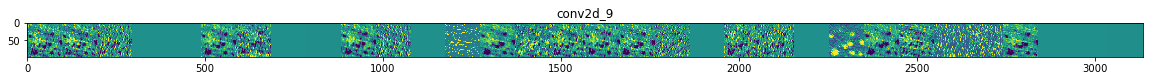

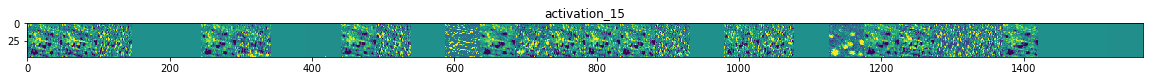

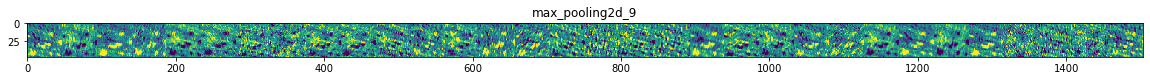

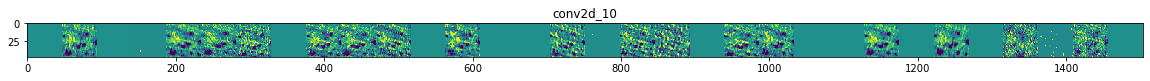

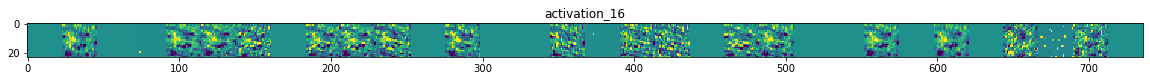

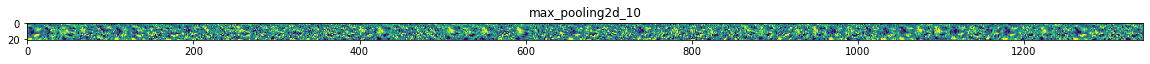

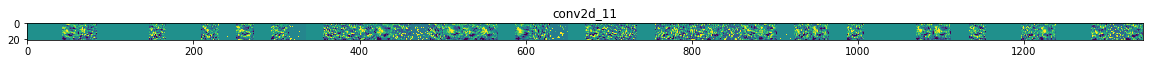

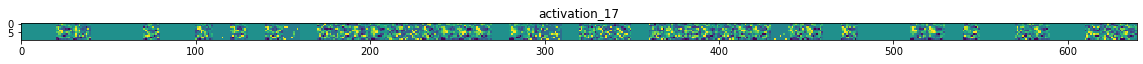

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
import os
import numpy as np
import matplotlib.pyplot as plt

img_path='../../sensix_daninhas/dataset_100x100/validation/daninha/daninha_8.jpg' #dog
# Define a new Model, Input= image 
# Output= intermediate representations for all layers in the  
# previous model after the first.
successive_outputs = [layer.output for layer in model.layers[1:]]#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)#Load the input image
img = load_img(img_path, target_size=(100, 100))# Convert ht image to Array of dimension (150,150,3)
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)# Rescale by 1/255
x /= 255.0# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
        x  = feature_map[0, :, :, i]
        x -= x.mean()
        if x.std()>0:
                x /= x.std()
        x *=  64
        x += 128
        x  = np.clip(x, 0, 255).astype('uint8')
        # Tile each filter into a horizontal grid
        display_grid[:, i * size : (i + 1) * size] = x# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

In [34]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=100, 
        verbose=1, mode='auto', restore_best_weights=True)

history = model.fit(train_generator,
                    steps_per_epoch=num_of_train_samples // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=num_of_test_samples // batch_size,
                    #callbacks=[monitor],verbose=2 # interrompe quando o overfiting começa
                    )

Y_pred_model = model.predict(validation_generator, num_of_test_samples // batch_size)
y_pred_model = np.argmax(Y_pred_model, axis=1)
print("Real :       ", validation_generator.classes)
print("Prediction : ", y_pred_model)
print('Confusion ValueError: could not broadcast input array from shape (1,100,100) into shape (100,100,3)Matrix')
print(confusion_matrix(validation_generator.classes, y_pred_model))

Epoch 1/300


ValueError: in user code:

    /home/hericles/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/hericles/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/hericles/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/hericles/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/hericles/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/hericles/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/hericles/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:755 train_step
        loss = self.compiled_loss(
    /home/hericles/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/hericles/.local/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /home/hericles/.local/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/hericles/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/hericles/.local/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1537 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /home/hericles/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/hericles/.local/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4833 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /home/hericles/.local/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 2) are incompatible


In [25]:
!pip3 install graphviz

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [27]:
#scores = model.evaluate(train_generator, validation_generator)
#print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

from ann_visualizer.visualize import ann_viz;

ann_viz(model, title="My first neural network")

In [14]:
model_reduced = Sequential()
model_reduced.add(Convolution2D(32, (3, 3), input_shape=(img_rows, img_cols, n_channels), padding='valid'))
model_reduced.add(Activation('relu'))
model_reduced.add(MaxPooling2D(pool_size=(2, 2)))
model_reduced.add(Convolution2D(64, (3, 3), padding='valid'))
model_reduced.add(Activation('relu'))
model_reduced.add(MaxPooling2D(pool_size=(2, 2)))
model_reduced.add(Flatten())
model_reduced.add(Dense(64))
model_reduced.add(Activation('relu'))
model_reduced.add(Dropout(0.5))
model_reduced.add(Dense(2))
model_reduced.add(Activation('sigmoid'))

In [15]:
model_reduced.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=100, 
        verbose=1, mode='auto', restore_best_weights=True)

history_model_reduced = model_reduced.fit(train_generator,
                    steps_per_epoch=num_of_train_samples // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=num_of_test_samples // batch_size,
                    #callbacks=[monitor],verbose=2 # interrompe quando o overfiting começa
                    )

Y_pred_model_reduced = model_reduced.predict(validation_generator, num_of_test_samples // batch_size)
y_pred_model_reduced = np.argmax(Y_pred_model_reduced, axis=1)
print("Real :       ", validation_generator.classes)
print("Prediction : ", y_pred_model_reduced)
print(confusion_matrix(validation_generator.classes, y_pred_model_reduced))

Epoch 1/100
99/99 [==============================] - 4s 33ms/step - loss: 1.0919 - accuracy: 0.5297 - val_loss: 0.7079 - val_accuracy: 0.5000
Epoch 2/100
99/99 [==============================] - 3s 31ms/step - loss: 0.7182 - accuracy: 0.4335 - val_loss: 0.6919 - val_accuracy: 0.4792
Epoch 3/100
99/99 [==============================] - 3s 33ms/step - loss: 0.7233 - accuracy: 0.4969 - val_loss: 0.6927 - val_accuracy: 0.5208
Epoch 4/100
99/99 [==============================] - 3s 33ms/step - loss: 0.7170 - accuracy: 0.5239 - val_loss: 0.7014 - val_accuracy: 0.5208
Epoch 5/100
99/99 [==============================] - 3s 32ms/step - loss: 0.7316 - accuracy: 0.5055 - val_loss: 0.7056 - val_accuracy: 0.4792
Epoch 6/100
99/99 [==============================] - 3s 31ms/step - loss: 0.7302 - accuracy: 0.5026 - val_loss: 0.6927 - val_accuracy: 0.5208
Epoch 7/100
99/99 [==============================] - 3s 31ms/step - loss: 0.7282 - accuracy: 0.4529 - val_loss: 0.6953 - val_accuracy: 0.5000
Epoch 

In [16]:
bigger_model = Sequential()
#bigger_model.add.Conv2D(64, 
bigger_model.add(Flatten(input_shape = (img_rows, img_cols, n_channels))),
bigger_model.add(Dense(256)),
bigger_model.add(Activation('relu'))
bigger_model.add(Dropout(0.25)),
bigger_model.add(Dense(128)),
bigger_model.add(Activation('relu'))
bigger_model.add(Dropout(0.25)),
bigger_model.add(Dense(64)),
bigger_model.add(Activation('relu'))
bigger_model.add(Dropout(0.5)),
bigger_model.add(Dense(16)),
bigger_model.add(Activation('relu'))
bigger_model.add(Dense(2, activation=tf.nn.softmax))
bigger_model.add(Activation('sigmoid'))
    

bigger_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

bigger_model_history = bigger_model.fit(train_generator,
                                        steps_per_epoch=num_of_train_samples // batch_size,
                                        epochs=epochs,
                                        validation_data=validation_generator,
                                        validation_steps=num_of_test_samples // batch_size,
                                        #callbacks=[monitor],verbose=2 # interrompe quando o overfiting começa
                                        )

Y_pred_bigger_model = bigger_model.predict(validation_generator, num_of_test_samples // batch_size)
y_pred_bigger_model = np.argmax(Y_pred_bigger_model, axis=1)
print("Real :       ", validation_generator.classes)
print("Prediction : ", y_pred_bigger_model)
print('Confusion ValueError: could not broadcast input array from shape (1,100,100) into shape (100,100,3)Matrix')
print(confusion_matrix(validation_generator.classes, y_pred_bigger_model))

Epoch 1/100
99/99 [==============================] - 6s 51ms/step - loss: 0.7836 - accuracy: 0.5395 - val_loss: 0.8133 - val_accuracy: 0.5000
Epoch 2/100
99/99 [==============================] - 5s 51ms/step - loss: 0.7877 - accuracy: 0.5255 - val_loss: 0.7924 - val_accuracy: 0.5208
Epoch 3/100
99/99 [==============================] - 5s 51ms/step - loss: 0.8544 - accuracy: 0.4586 - val_loss: 0.8133 - val_accuracy: 0.5000
Epoch 4/100
99/99 [==============================] - 5s 52ms/step - loss: 0.7649 - accuracy: 0.5484 - val_loss: 0.8133 - val_accuracy: 0.5000
Epoch 5/100
99/99 [==============================] - 5s 54ms/step - loss: 0.7828 - accuracy: 0.5266 - val_loss: 0.8133 - val_accuracy: 0.5000
Epoch 6/100
99/99 [==============================] - 7s 71ms/step - loss: 0.8506 - accuracy: 0.4619 - val_loss: 0.8341 - val_accuracy: 0.4792
Epoch 7/100
99/99 [==============================] - 6s 61ms/step - loss: 0.7753 - accuracy: 0.5380 - val_loss: 0.8133 - val_accuracy: 0.5000
Epoch 

In [17]:
baseline_model = Sequential()
baseline_model.add(Flatten(input_shape = (img_rows, img_cols, n_channels))),
baseline_model.add(Dense(128)),
baseline_model.add(Activation('relu'))
baseline_model.add(Dropout(0.25)),
baseline_model.add(Dense(16)),
baseline_model.add(Activation('relu'))
baseline_model.add(Dense(2))
baseline_model.add(Activation('sigmoid'))


baseline_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

baseline_model_history = baseline_model.fit(train_generator,
                                        steps_per_epoch=num_of_train_samples // batch_size,
                                        epochs=epochs,
                                        validation_data=validation_generator,
                                        validation_steps=num_of_test_samples // batch_size,
                                        #callbacks=[monitor],verbose=2 # interrompe quando o overfiting começa
                                        )

Y_pred_baseline_model = baseline_model.predict(validation_generator, num_of_test_samples // batch_size)
y_pred_baseline_model = np.argmax(Y_pred_baseline_model, axis=1)
print("Real :       ", validation_generator.classes)
print("Prediction : ", y_pred_baseline_model)
print(confusion_matrix(validation_generator.classes, y_pred_baseline_model))

Epoch 1/100
99/99 [==============================] - 3s 28ms/step - loss: 12.6967 - accuracy: 0.6007 - val_loss: 1.0441 - val_accuracy: 0.4792
Epoch 2/100
99/99 [==============================] - 3s 26ms/step - loss: 2.1049 - accuracy: 0.4283 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/100
99/99 [==============================] - 3s 26ms/step - loss: 1.4025 - accuracy: 0.6166 - val_loss: 0.6915 - val_accuracy: 0.5208
Epoch 4/100
99/99 [==============================] - 3s 26ms/step - loss: 0.7558 - accuracy: 0.5296 - val_loss: 0.7097 - val_accuracy: 0.5000
Epoch 5/100
99/99 [==============================] - 3s 26ms/step - loss: 0.9153 - accuracy: 0.4957 - val_loss: 0.6895 - val_accuracy: 0.5208
Epoch 6/100
99/99 [==============================] - 3s 26ms/step - loss: 0.7018 - accuracy: 0.4826 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 7/100
99/99 [==============================] - 3s 25ms/step - loss: 0.6957 - accuracy: 0.4724 - val_loss: 0.6946 - val_accuracy: 0.4792
Epoch

In [18]:
bigger_model1 = keras.models.Sequential()
bigger_model1.add(Flatten(input_shape = (img_rows, img_cols, n_channels))),
bigger_model1.add(Dense(128, activation=tf.nn.relu)),
bigger_model1.add(Activation('relu'))
bigger_model1.add(Dropout(0.25))
bigger_model1.add(Dense(64))
bigger_model1.add(Activation('relu'))
bigger_model1.add(Dropout(0.5))
bigger_model1.add(Dense(16))
bigger_model1.add(Activation('relu'))
bigger_model1.add(Dense(2))
bigger_model1.add(Activation('sigmoid'))

bigger_model1.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

bigger_model1_history = bigger_model1.fit(train_generator,
                                        steps_per_epoch=num_of_train_samples // batch_size,
                                        epochs=epochs,
                                        validation_data=validation_generator,
                                        validation_steps=num_of_test_samples // batch_size,
                                        #callbacks=[monitor],verbose=2 # interrompe quando o overfiting começa
                                        )

Y_pred_bigger_model1 = bigger_model1.predict(validation_generator, num_of_test_samples // batch_size)
y_pred_baseline_model = np.argmax(Y_pred_baseline_model, axis=1)
print("Real :       ", validation_generator.classes)
print("Prediction : ", y_pred_baseline_model)
print(confusion_matrix(validation_generator.classes, y_pred_baseline_model))

Epoch 1/100
99/99 [==============================] - 3s 28ms/step - loss: 13.2937 - accuracy: 0.5313 - val_loss: 0.7647 - val_accuracy: 0.5208
Epoch 2/100
99/99 [==============================] - 3s 26ms/step - loss: 1.7547 - accuracy: 0.4998 - val_loss: 0.6926 - val_accuracy: 0.5208
Epoch 3/100
99/99 [==============================] - 2s 25ms/step - loss: 0.6918 - accuracy: 0.5559 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/100
99/99 [==============================] - 3s 25ms/step - loss: 0.7221 - accuracy: 0.5078 - val_loss: 0.6927 - val_accuracy: 0.5208
Epoch 5/100
99/99 [==============================] - 2s 25ms/step - loss: 0.6938 - accuracy: 0.4781 - val_loss: 0.6926 - val_accuracy: 0.5208
Epoch 6/100
99/99 [==============================] - 3s 26ms/step - loss: 0.6924 - accuracy: 0.5280 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 7/100
99/99 [==============================] - 3s 25ms/step - loss: 0.6935 - accuracy: 0.4977 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch

In [19]:
smaller_model1 = keras.models.Sequential()
smaller_model1.add(Flatten(input_shape = (img_rows, img_cols, n_channels)))
smaller_model1.add(Dense(64))
smaller_model1.add(Activation('relu'))
smaller_model1.add(Dense(2))
smaller_model1.add(Activation('sigmoid'))

smaller_model1.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

smaller_model1_history = smaller_model1.fit(train_generator,
                                            steps_per_epoch=num_of_train_samples // batch_size,
                                            epochs=epochs,
                                            validation_data=validation_generator,
                                            validation_steps=num_of_test_samples // batch_size,
                                            #callbacks=[monitor],verbose=2 # interrompe quando o overfiting começa
                                            )
                   
Y_pred_smaller_model1 = smaller_model1.predict(validation_generator, num_of_test_samples // batch_size)
y_pred_smaller_model1 = np.argmax(Y_pred_smaller_model1, axis=1)
#print(Y_pred)
print("Real :       ", validation_generator.classes)
print("Prediction : ", y_pred_smaller_model1)
print(confusion_matrix(validation_generator.classes, y_pred_smaller_model1))

Epoch 1/100
99/99 [==============================] - 2s 16ms/step - loss: 8.9756 - accuracy: 0.5326 - val_loss: 0.6931 - val_accuracy: 0.5208
Epoch 2/100
99/99 [==============================] - 2s 15ms/step - loss: 0.9763 - accuracy: 0.4897 - val_loss: 0.6930 - val_accuracy: 0.5208
Epoch 3/100
99/99 [==============================] - 2s 16ms/step - loss: 0.8770 - accuracy: 0.5901 - val_loss: 0.6929 - val_accuracy: 0.5208
Epoch 4/100
99/99 [==============================] - 1s 15ms/step - loss: 0.6935 - accuracy: 0.4987 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/100
99/99 [==============================] - 2s 16ms/step - loss: 0.7134 - accuracy: 0.5115 - val_loss: 0.6927 - val_accuracy: 0.5208
Epoch 6/100
99/99 [==============================] - 2s 16ms/step - loss: 0.6937 - accuracy: 0.4834 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/100
99/99 [==============================] - 2s 16ms/step - loss: 0.6938 - accuracy: 0.4856 - val_loss: 0.6927 - val_accuracy: 0.5208
Epoch 

In [20]:
Y_pred = model.predict(validation_generator, num_of_test_samples // batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print("Real :       ", validation_generator.classes)
print("Prediction : ", y_pred)
print('Confusion ValueError: could not broadcast input array from shape (1,100,100) into shape (100,100,3)Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Real :        [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
Prediction :  [1 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 1 0]
Confusion ValueError: could not broadcast input array from shape (1,100,100) into shape (100,100,3)Matrix
[[ 8 16]
 [ 5 20]]


In [21]:
print('Classification Report')
target_names = ['daninhas', 'sem_daninhas']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

    daninhas       0.62      0.33      0.43        24
sem_daninhas       0.56      0.80      0.66        25

    accuracy                           0.57        49
   macro avg       0.59      0.57      0.54        49
weighted avg       0.58      0.57      0.55        49



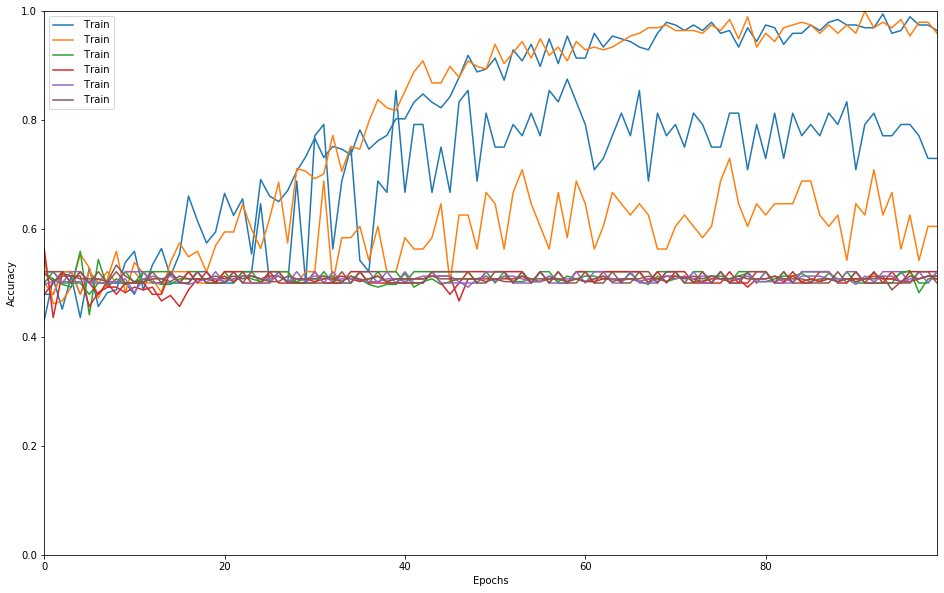

In [22]:
def map_accuracy(*names, key='accuracy'):
    '''
    names: conjunto de nomes de histories gerados a partir do model.fit(), cada
    nome adicionado fará com que um modelo a mais seja considerado no mapamento 
    geral de acuracias:
    
    description: É feito para analisar um conjunto grande de modelos treinados,
    os histories aqui gerados irão ser comparados, inserindo variás curvas no 
    mesmo gráfico
    
    return: tupla de arrays
    retorna um array de histories em conjunto com um array de resultados de 
    acurácia. O indx do melhor resutado de acurácia é armazenado e salvo para
    plotagem individual
    '''
    _count = 0
    result_value = []
    plt.figure(figsize=(16,10))
    for history_name in names:
        result_value.append(history_name.history['accuracy'][-1])
        _count += 1
        key='accuracy'
        val = plt.plot(history.epoch, history_name.history['val_'+key])
        plt.plot(history.epoch, history_name.history[key], color=val[0].get_color(), label=' Train')
        plt.xlabel('Epochs')
        plt.ylabel(key.replace('_',' ').title())
        plt.legend()
        plt.xlim([0, max(history.epoch)])
        plt.ylim([0, 1])

    return result_value, names 

values, histories = map_accuracy(history, history_model_reduced, bigger_model_history, baseline_model_history, bigger_model1_history, smaller_model1_history)

0
0.9644669890403748


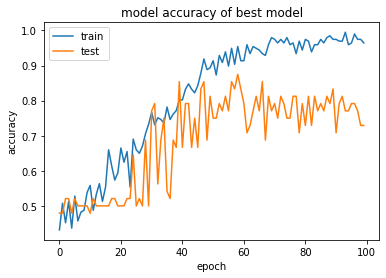

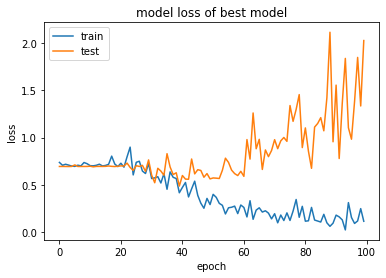

In [23]:
for i in range(0, len(values), 1):
    if values[i] == max(values):
        index = i 
key='accuracy'
print(index)
print(histories[index].history['accuracy'][-1])
plt.plot(histories[index].history['accuracy'])
plt.plot(histories[index].history['val_accuracy'])
plt.title('model accuracy of best model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss of best model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [24]:
print(history.history['accuracy'][-1])
    
result = [history.history['accuracy'][-1], bigger_model_history.history['accuracy'][-1], 
            baseline_model_history.history['accuracy'][-1], bigger_model1_history.history['accuracy'][-1],
            smaller_model1_history.history['accuracy'][-1]]

print(result[1])

0.9644669890403748
0.5076141953468323


In [25]:
def plot_history(histories, key='accuracy'):
    plt.figure(figsize=(16,10))
    
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],'--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                label=name.title()+' Train')

        plt.xlabel('Epochs')
        plt.ylabel(key.replace('_',' ').title())
        plt.legend()
        plt.xlim([0, max(history.epoch)])
        plt.ylim([0, 1])

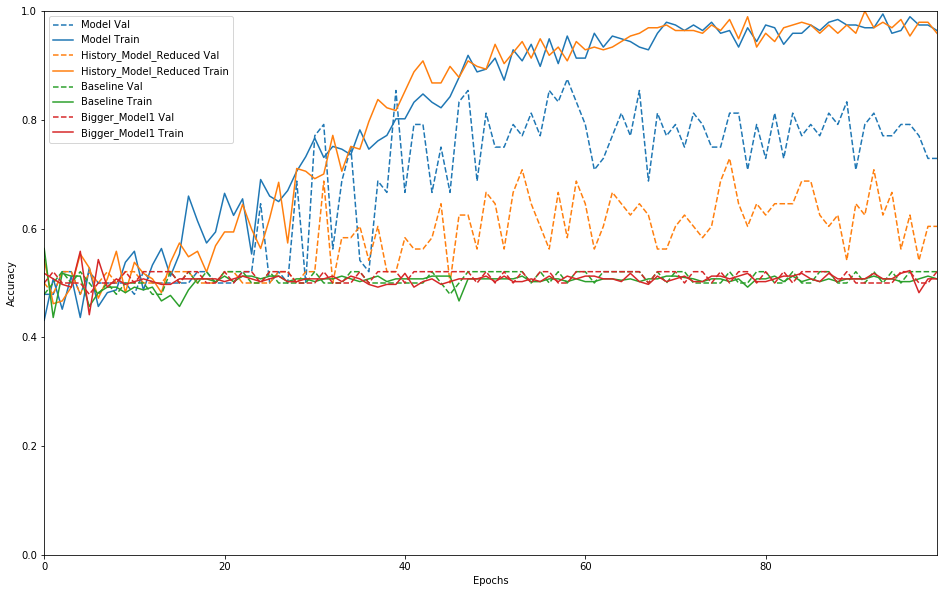

In [26]:
plot_history([
             ('model', history),
             ('history_model_reduced', history_model_reduced),
             ('baseline', baseline_model_history),
             ('bigger_model1', bigger_model_history)
             #('vgg', vgg_style_model_history)
             ])

0.9644669890403748


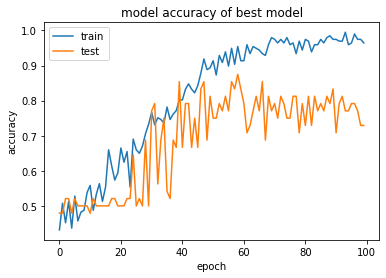

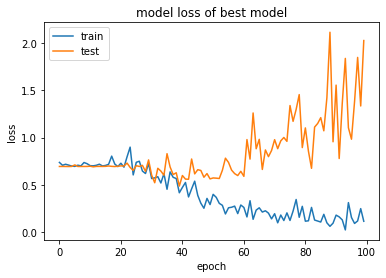

In [27]:
print(history.history['accuracy'][-1])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy of best model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss of best model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
image_path = '../../sensix_daninhas/dataset_100x100/validation/daninha'

images = []

for img in os.listdir(image_path):
        img = os.path.join(image_path, img)
        img = image.load_img(img, target_size=(100,100))
        img = image.img_to_array(img)
        #print(img)
        img = np.expand_dims(img, axis=0)
        processed_image = np.array(img, dtype="float")
        images.append(processed_image)
        
images = np.vstack(images)
print(len(images))

24


count_daninha 9
count_sem_daninha 15


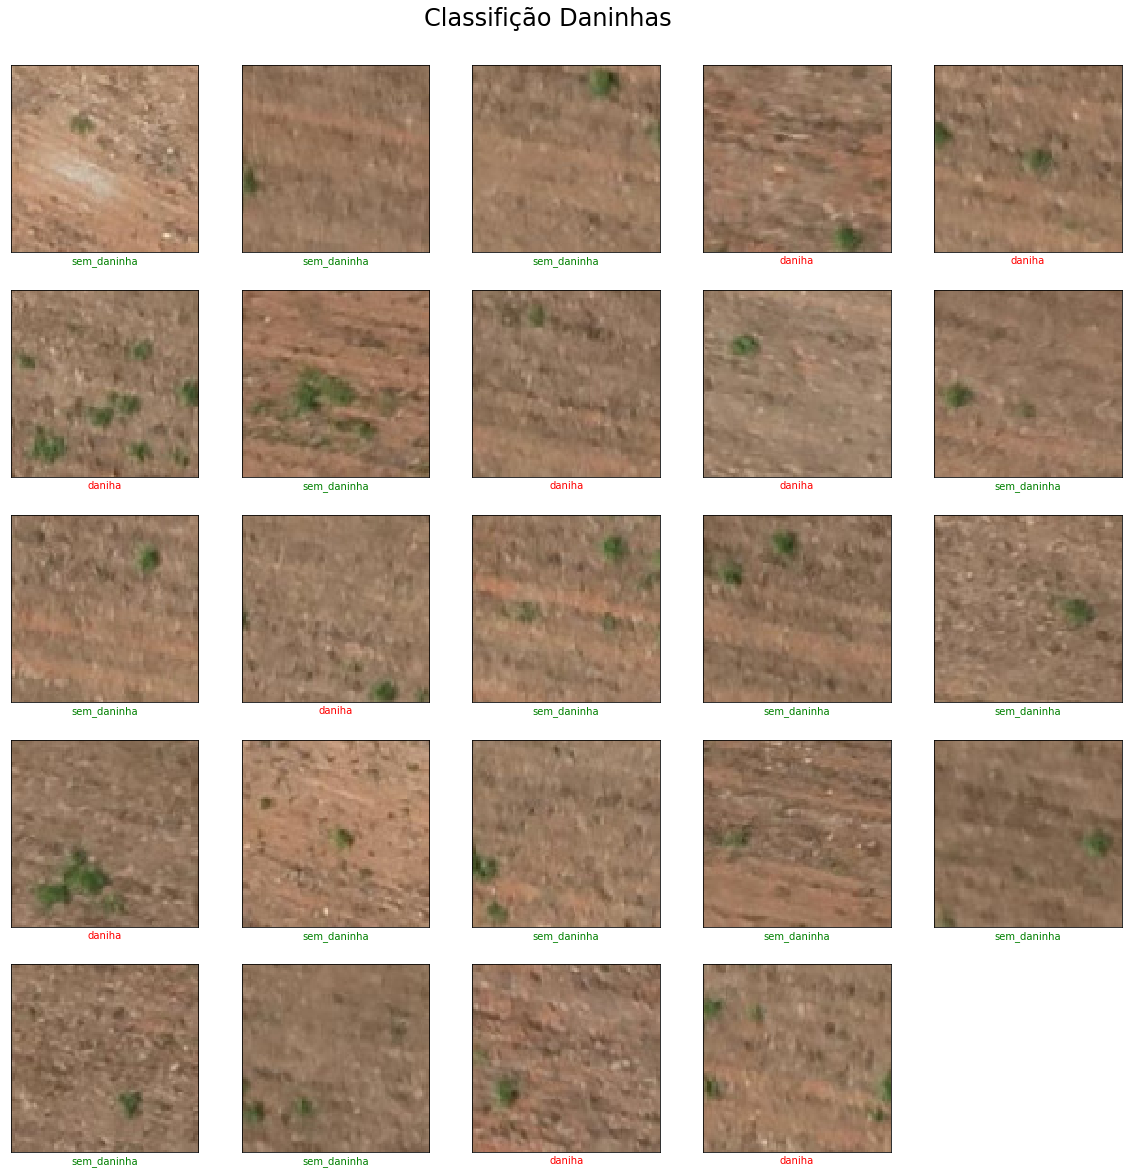

In [29]:
images_data = []
filenames = []
count_daninha = 0
count_sem_daninha = 0
count = 0
pred_result = model.predict(validation_generator, len(images) // batch_size+1)
#print(pred_result)
plt.figure(figsize=(20,20))
grid_size = min(0, len(pred_result))

for filename in os.listdir(image_path):
    images_data.append(pred_result)
    filenames.append(filename)
    plt.subplot(5, 5, count+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[count].astype(np.int32), cmap=plt.cm.binary)
    if pred_result[count][0]> pred_result[count][1]:
        legend_x = plt.xlabel("daniha")
        legend_x.set_color("red")
        count_daninha = count_daninha + 1
        if count >= num_of_test_samples -1:
            break
    else :
        legend_x = plt.xlabel("sem_daninha")
        legend_x.set_color("green")
        count_sem_daninha = count_sem_daninha + 1
    count += 1

print("count_daninha", count_daninha)
print("count_sem_daninha", count_sem_daninha)
plt.suptitle('Classifição Daninhas', y = 0.92, fontsize=24)
plt.show(images_data)

In [30]:
import os
# Directory with our training horse pictures
train_daninhas_dir = os.path.join('../../sensix_daninhas/dataset_100x100/train/daninha')
 
# Directory with our training human pictures
train_sem_daninhas_dir = os.path.join('../../sensix_daninhas/dataset_100x100/train/sem_daninha')

train_daninhas_names = os.listdir(train_daninhas_dir)
print('Total Daninhas     = ', len(train_daninhas_names))
train_sem_daninhas_names = os.listdir(train_sem_daninhas_dir)
print('Total Sem_Daninhas = ', len(train_sem_daninhas_names))

Total Daninhas     =  98
Total Sem_Daninhas =  101


In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        1

../../sensix_daninhas/dataset_100x100/train/daninha/daninha_15.jpg


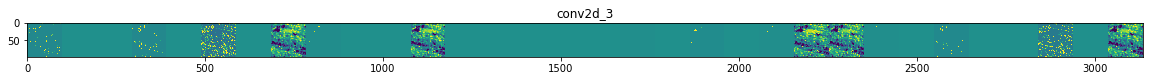

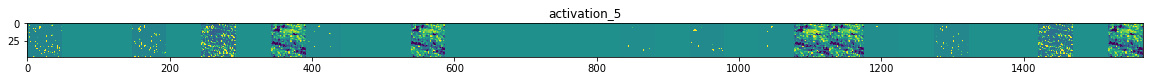

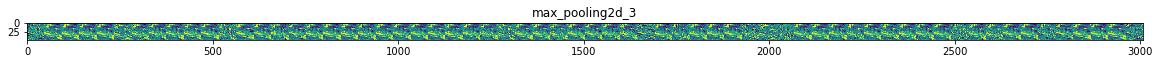

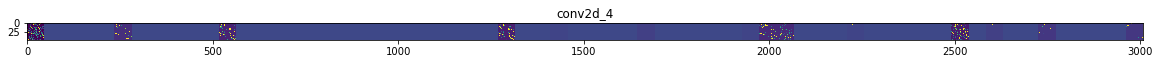

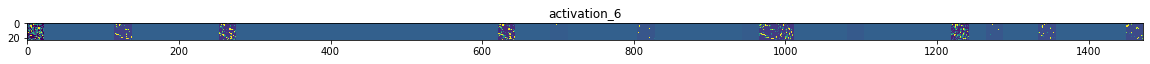

In [31]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
%matplotlib inline
 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
 
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4
 
# Index for iterating over images
pic_index = 0
    
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model_reduced.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model_reduced.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_daninhas_dir, f) for f in train_daninhas_names]
human_img_files = [os.path.join(train_sem_daninhas_dir, f) for f in train_sem_daninhas_names]
img_path = random.choice(horse_img_files + human_img_files)
print(img_path)
img = load_img(img_path, target_size=(100, 100))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)
 
# Rescale by 1/255
x /= 255
 
# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)
 
# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model_reduced.layers]
 
# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      if x.std()>0:
        x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')